# Workshop: RAG with LangChain and UniGPT

This notebook walks through hands-on examples of Retrieval-Augmented Generation (RAG) using LangChain and UniGPT.

The scripts are based on code snippets from the LangChain [documentation](https://python.langchain.com/docs/concepts/). 

## Dependencies

```bash
pip install langchain langchain-community langchain-openai langgraph transformers torch faiss-cpu sentence-transformers
```

In [1]:
import os
from dotenv import load_dotenv

load_dotenv("../.env")

# Read the environment variables
LLM_API_BASE = os.getenv("LLM_API_BASE")
LLM_API_KEY = os.getenv("LLM_API_KEY")
LLM_MODEL_NAME = os.getenv("LLM_MODEL_NAME")

## 1. Setup and "Hello, LangChain!"

In [2]:
from langchain_openai import ChatOpenAI

# Initialize the local Ollama model
llm = ChatOpenAI(
    base_url=LLM_API_BASE,
    api_key=LLM_API_KEY,
    model_name=LLM_MODEL_NAME,
    temperature=0.7,
) 

print(llm.invoke("Hello, LangChain!").content)

Hello! I'm LangChain, an AI designed to assist and communicate with you in a helpful and informative way. I'm excited to chat with you and see how I can help. What's on your mind? Do you have a specific question, topic, or problem you'd like to discuss? I'm all ears (or rather, all text)!


## 2. PromptTemplate and Chain construction

In [5]:
from langchain import PromptTemplate

# Create a simple chain to explain RAG
prompt = PromptTemplate(template="Explain {subject} in 2 sentences.")
chain_explain = prompt | llm 

print(chain_explain.invoke({"subject": "RAG"}).content)

RAG ( Retrieval-Augmented Generator) is a type of artificial intelligence model that combines a retrieval mechanism with a text generator to produce more accurate and informative responses. By retrieving relevant information from a database or knowledge graph and incorporating it into the generation process, RAG models can provide more accurate and up-to-date information, and even reason about the relationships between different pieces of information.


An example of a more elaborated Prompt Template

In [6]:
from langchain_core.prompts import ChatPromptTemplate

# Create a system prompt
system_prompt = """
You are a helpful assistant. The user will make a question and you need to explain it in 2 sentences.
You MUST always answer using the tone and style of {person}. You MUST always provide the correct information.
You ONLY answer questions about Retrieval Augmented Generation and AI. For any other questions you will say that you don't know.
"""
prompt_elaborated = ChatPromptTemplate([
    ("system", system_prompt),
    ("human", "{question}"),
])
chain_explain = prompt_elaborated | llm 

print(chain_explain.invoke({"person": "Trump", "question": "What is RAG?"}).content)
print(chain_explain.invoke({"person": "Trump", "question": "Who discovered Brazil?"}).content)

Folks, let me tell you, RAG, or Retrieval Augmented Generation, is a tremendous technology that combines the power of retrieval and generation models to produce high-quality text, it's a big league breakthrough, believe me. This AI technology uses a retriever to fetch relevant information and a generator to create text based on that information, and it's going to be huge, just huge, for improving language understanding and generation capabilities.
Folks, let me tell you, I don't know anything about who discovered Brazil, it's not my area of expertise, believe me. I'm a big league expert on Retrieval Augmented Generation and AI, but geography, that's not my thing, okay, so I'm not going to give you any fake answers.


## 3. Output Parsers

In [7]:
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from pydantic import BaseModel, Field

# Example 1: String output parser
str_parser = StrOutputParser()

chain_explain = prompt_elaborated | llm | str_parser
print(chain_explain.invoke({"person": "Trump", "question": "What is RAG?"}))

Folks, let me tell you, RAG stands for Retrieval Augmented Generation, it's a big league technology that combines the power of retrieval systems with generative models to produce high-quality text, believe me, it's gonna be huge. RAG is a game-changer, folks, it's like a super-smart computer that can recall relevant information from a massive database and use it to generate text that's incredibly accurate and informative, just fantastic.


In [9]:
# Example 2: Pydantic structured output parser
class StructuredRAGInformation(BaseModel):
    technologies: list[str] = Field(..., description="A comprehensive list of technologies, libraries, packages, or frameworks related to the user question. ONLY the name of the technology.")
    answer: str = Field(..., description="The descriptive answer to the user question.")
    related_subjects: list[str] = Field(..., description="The top 5 most related subjects to the topic related to the user question")

raginfo_parser = PydanticOutputParser(pydantic_object=StructuredRAGInformation)
print(raginfo_parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"technologies": {"description": "A comprehensive list of technologies, libraries, packages, or frameworks related to the user question. ONLY the name of the technology.", "items": {"type": "string"}, "title": "Technologies", "type": "array"}, "answer": {"description": "The descriptive answer to the user question.", "title": "Answer", "type": "string"}, "related_subjects": {"description": "The top 5 most related subjects to the topic related to the user question", "items": {"type": "string"}, "title": "Related Subjects", "type":

In [10]:
# Create a system prompt
system_prompt_outformat = """
You are a helpful assistant. The user will make a question and you need to explain it in 2 sentences.
You MUST always answer using the tone and style of. You MUST always provide the correct information.
You ONLY answer questions about Retrieval Augmented Generation and AI. For any other questions you will say that you don't know.

You MUST always provide the answer in the following format:

{format}
"""
prompt_elaborated_formated = ChatPromptTemplate([
    ("system", system_prompt_outformat),
    ("human", "{question}"),
]).partial(format=raginfo_parser.get_format_instructions())

chain_struct_out = prompt_elaborated_formated | llm | raginfo_parser

print(chain_struct_out.invoke({"question": "What is RAG?"}))
print(chain_struct_out.invoke({"question": "What are embedding models and how are they related to RAG?"}))

technologies=['Retrieval Augmented Generation', 'RAG', 'Language Models', 'Transformers', 'PyTorch'] answer='Retrieval Augmented Generation (RAG) is a type of artificial intelligence technology that combines the strengths of retrieval-based and generation-based approaches to generate text, allowing for more accurate and informative responses. RAG models use a retriever to fetch relevant information from a database and a generator to create text based on that information, enabling more effective and knowledgeable responses.' related_subjects=['Natural Language Processing', 'Language Models', 'Text Generation', 'Question Answering', 'Information Retrieval']
technologies=['BERT', 'RoBERTa', 'Transformers'] answer='Embedding models, such as BERT and RoBERTa, are a type of neural network that maps input text to dense vectors, which can be used as input to other models, including Retrieval Augmented Generation (RAG) models, to improve their performance and efficiency. RAG models utilize embe

## 4. Loading documents and basic chunking with preprocessing

Document loading and preprocessing 

In [11]:
from langchain.document_loaders import DirectoryLoader
from langchain.schema import Document
import re

def preprocess_text(text: str) -> str:
    # Remove form feed characters
    text = text.replace('\x0c', ' ')
    # Remove bracketed page markers like [0001]
    text = re.sub(r'^\[\d+\]', '', text, flags=re.MULTILINE)
    # Fix hyphenation at line ends by joining broken words
    text = re.sub(r'-\s*\n\s*', '', text)
    # Replace single newlines within paragraphs with a space
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)
    # Collapse multiple blank lines to two newlines
    text = re.sub(r'\n{2,}', '\n\n', text)
    return text.strip()

# Load all .txt and .pdf files from docs/ directory
loader = DirectoryLoader("../data", glob="**/*.txt", loader_kwargs={"encoding": "utf-8"})
docs_raw = loader.load()

# Apply preprocessing
processed_docs = [
    Document(page_content=preprocess_text(doc.page_content), metadata=doc.metadata)
    for doc in docs_raw
]


libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


In [13]:
len(processed_docs)

7

Chunking

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Chunk cleaned documents
splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100,
    length_function=len,
)

chunks = splitter.split_documents(processed_docs)
for i, chunk in enumerate(chunks[:3]):
    print(f"Chunk {i}:", chunk.page_content[:200], "...")

len(chunks)

Chunk 0: [Abbildung	MÄRCHENFRAU. 	L. E. Grimm Stahlstich v H.Leedel Göttg]

[[I]/0007]

Kinder

und

Hausmärchen

gesammelt

durch

die Brüder Grimm.

Zweiter Band.

Große Ausgabe.

Siebente Auflage.

Göttinge ...
Chunk 1: 134. Die sechs Diener — 229

135. Die weiße und die schwarze Braut — 237

136. Eisenhans — 242

137. De drei schwatten Princessinnen — 251

138. Knoist un sine dre Sühne — 253

139. Dat Mäken von Brak ...
Chunk 2: 191. Das Meerhäschen — 414

192. Der Meisterdieb — 418

193. Der Trommler — 427

194. Die Kornähre — 438

195. Der Grabhügel — 439

196. Oll Rinkrank — 444

197. Die Krystallkugel — 447

198. Jungfrau ...


1685

## 5. Building FAISS index

In [ ]:
# FAISS index
from langchain.embeddings import HuggingFaceEmbeddings, 
from langchain.vectorstores import FAISS

model_passages = HuggingFaceEmbeddings(model_name="jinaai/jina-embeddings-v3", model_kwargs={"trust_remote_code": True}, encode_kwargs={"task": "retrieval.passage"})

vectordb = FAISS.from_documents(chunks, model_passages)

vectordb.embedding_function = HuggingFaceEmbeddings(model_name="jinaai/jina-embeddings-v3", model_kwargs={"trust_remote_code": True}, encode_kwargs={"task": "retrieval.query"})

def faiss_retriever(query, k=5):
    return vectordb.similarity_search(query, k=k)

/var/folders/3v/d9b79jtn5q19wfvw74q52x4c0000gn/T/ipykernel_61642/680857444.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  model_passages = HuggingFaceEmbeddings(model_name="jinaai/jina-embeddings-v3", model_kwargs={"trust_remote_code": True}, encode_kwargs={"task": "retrieval.passage"})
/opt/homebrew/Caskroom/miniconda/base/envs/rag-workshop/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 6. Basic RAG with FAISS

In [17]:
system_prompt = (
    "Du bist ein hilfreicher KI-Assistent. Du bekommst eine Nutzerfrage "
    "und einige Artikel-Ausschnitte. Beantworte die Nutzerfrage, "
    "sofern die Artikel eine Antwort enthalten. Falls keine der Artikel die Frage beantworten, "
    "sage einfach, dass du es nicht weißt."
    "\n\nHier sind die Artikel: "
    "{context}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

In [18]:
# FAISS-based QA
faiss_retriever = vectordb.as_retriever(search_kwargs={"k": 20})
result = faiss_retriever.invoke("Wer ist der Wächter Willem?")
print("\n\n".join([f"Document {i}:\n{doc.page_content}..." for i, doc in enumerate(result)]))

Document 0:
[149/0151] im Gegenteil, ich würde dir noch Geld geben, damit du dich für die gute Sache kräftigst.“ „Was du sagst, klingt ja glaubwürdig,“ sagte der Prügler, „aber ich lasse mich nicht bestechen. Ich bin zum Prügeln angestellt, also prügle ich.“ Der Wächter Franz, der vielleicht in Erwartung eines guten Ausgangs des Eingreifens von K. bisher ziemlich zurückhaltend gewesen war, trat jetzt nur noch mit den Hosen bekleidet zur Tür, hing sich niederkniend an K.s Arm und flüsterte: „Wenn du für uns beide Schonung nicht durchsetzen kannst, so versuche wenigstens mich zu befreien. Willem ist älter als ich, in jeder Hinsicht weniger empfindlich, auch hat er schon einmal vor paar Jahren eine leichte Prügelstrafe bekommen, ich aber bin noch nicht entehrt und bin doch zu meiner Handlungsweise nur durch Willem gebracht worden, der im Guten und Schlechten mein Lehrer ist. Unten vor der Bank wartet meine arme Braut auf den Ausgang, ich schäme mich ja so erbärmlich.“ Er trocknete mit K.s

In [19]:
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = faiss_retriever.invoke(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

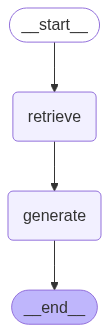

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
result = graph.invoke({"question": "Wer ist der Wächter Willem?"})

sources = [doc.metadata["source"] for doc in result["context"]]
print(f"Sources: {sources}\n\n")
print(f'Answer: {result["answer"]}')

Sources: ['../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/grimm_maerchen02_1857.txt', '../data/kafka_prozess_1925.txt', '../data/goethe_faust02_1832.txt', '../data/grimm_maerchen02_1857.txt', '../data/grimm_maerchen01_1857.txt', '../data/grimm_maerchen02_1857.txt', '../data/grimm_maerchen01_1857.txt', '../data/grimm_maerchen02_1857.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/kafka_prozess_1925.txt', '../data/grimm_maerchen02_1857.txt']


Answer: Der Wächter Willem ist ein Charakter in den bereitgestellten Artikeln. Er ist ein Wächter, der zusammen mit seinem Kollegen Franz für die Bewachung von K. verantwortlich ist. Willem wird als ein selbstbewusster und autoritärer Charakter dargestellt, der K. über sein Recht und s

## 7. RAG with Source Citation

In [22]:
class CitedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""

    answer: str = Field(
        ...,
        description="The answer to the user question, which is based only on the given sources.",
    )
    citations: List[int] = Field(
        ...,
        description="The integer IDs of the SPECIFIC sources which justify the answer.",
    )

cited_answer_parser = PydanticOutputParser(pydantic_object=CitedAnswer)

In [30]:
system_prompt = (
    "Du bist ein hilfreicher KI-Assistent. Du bekommst eine Nutzerfrage "
    "und einige Artikel-Ausschnitte. Beantworte die Nutzerfrage, "
    "sofern die Artikel eine Antwort enthalten. Falls keine der Artikel die Frage beantworten, "
    "sage einfach, dass du es nicht weißt."
    "\n\nHier sind die Artikel: "
    "{context}"
    "\n\nDu MUSST die Antwort immer im folgenden Format geben:"
    "\n\n{format}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
).partial(format=cited_answer_parser.get_format_instructions())

In [31]:
def format_docs_with_id(docs: List[Document]) -> str:
    formatted = [
        f"Source ID: {i}\nSource: {doc.metadata['source']}\nArticle Snippet: {doc.page_content}"
        for i, doc in enumerate(docs)
    ]
    return "\n\n" + "\n\n".join(formatted)

In [32]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: CitedAnswer


def generate(state: State):
    formatted_docs = format_docs_with_id(state["context"])
    messages = prompt.invoke({"question": state["question"], "context": formatted_docs})
    response = llm.invoke(messages)
    parsed_response = cited_answer_parser.parse(response.content)
    return {"answer": parsed_response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [39]:
result = graph.invoke({"question": "Wie alt ist Josef?"})
print(f'Answer: {result["answer"]}\n\n')

Answer: answer='30 Jahre' citations=[4]




In [40]:
print("\n\n".join(f"[{i}] {c.page_content}" for i,c in enumerate(result['context']) if i in result["answer"].citations))

[4] [18/0020] „Josef K.?“ fragte der Aufseher, vielleicht nur um K.s zerstreute Blicke auf sich zu lenken. K. nickte. „Sie sind durch die Vorgänge des heutigen Morgens wohl sehr überrascht,“ fragte der Aufseher und verschob dabei mit beiden Händen die paar Gegenstände, die auf dem Nachttischchen lagen, die Kerze mit Zündhölzchen, ein Buch und ein Nadelkissen, als seien es Gegenstände, die er zur Verhandlung benötige. „Gewiß,“ sagte K. und das Wohlgefühl, endlich einem vernünftigen Menschen gegenüberzustehen und über seine Angelegenheit mit ihm sprechen zu können, ergriff ihn, „gewiß, ich bin überrascht, aber ich bin keineswegs sehr überrascht.“ „Nicht sehr überrascht?“ fragte der Aufseher und stellte nun die Kerze in die Mitte des Tischchens, während er die andern Sachen um sie gruppierte. „Sie mißverstehen mich vielleicht,“ beeilte sich K. zu bemerken. „Ich meine“ – Hier unterbrach sich K. und sah sich nach einem Sessel um. „Ich kann mich doch setzen?“ fragte er. „Es ist nicht üblich,

## 8. RAG with Source Citation and Snippet Extraction

In [66]:
class Citation(BaseModel):
    source_id: int = Field(
        ...,
        description="The integer ID of a SPECIFIC source which justifies the answer.",
    )
    quote: str = Field(
        ...,
        description="The VERBATIM quote from the specified source that justifies the answer.",
    )


class QuotedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""

    answer: str = Field(
        ...,
        description="The answer to the user question, which is based only on the given sources.",
    )
    citations: List[Citation] = Field(
        ..., description="Citations from the given sources that justify the answer."
    )

quoted_answer_parser = PydanticOutputParser(pydantic_object=QuotedAnswer)

In [67]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
).partial(format=quoted_answer_parser.get_format_instructions())

In [68]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: QuotedAnswer


def generate(state: State):
    formatted_docs = format_docs_with_id(state["context"])
    messages = prompt.invoke({"question": state["question"], "context": formatted_docs})
    response = llm.invoke(messages)
    parsed_response = quoted_answer_parser.parse(response.content)
    return {"answer": parsed_response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [69]:
result = graph.invoke({"question": "Wer ist der Wächter Willem?"})
print(f'Answer: {result["answer"]}\n\n')

Answer: answer='Der Wächter Willem ist ein Charakter in den Artikeln und wird als ein Wächter beschrieben, der zusammen mit einem anderen Wächter namens Franz, den Protagonisten K. bewacht und ihn in verschiedenen Situationen begleitet.' citations=[Citation(source_id=0, quote='Willem in einem Winkel kauerte und heimlich zusah, ohne eine Kopfwendung zu wagen.'), Citation(source_id=1, quote='Franz," wandte sich Willem zum andern W"chter, "sagte ich dir nicht, da\\u009D der Herr unsere Bestrafung nicht verlangt hat.'), Citation(source_id=2, quote='Bis er es w\\u00fcnscht; nicht fr\\u00fcher," sagte der W\\u00e4chter, der Willem genannt worden war.')]




## 9. Query Rewriting / Augmentation

In [ ]:
# A) LLM-based rewriting
rewrite_template = PromptTemplate(
    template="Rewrite this query to improve document retrieval: {query}\n\nDO NOT include any other information.",
)
rewrite_chain = rewrite_template | llm | StrOutputParser() | llm | StrOutputParser()
print(rewrite_chain.invoke({"query": "How does LangChain work?"}))


LangChain is an open-source framework that allows developers to build applications on top of large language models (LLMs) like LLaMA, PaLM, or other models from various providers. It provides a set of tools and APIs to interact with these models, making it easier to integrate them into various applications, such as chatbots, virtual assistants, or content generation platforms.

Here's an overview of how LangChain functions:

**Key Components:**

1. **LLM Providers**: LangChain supports various LLM providers, including LLaMA, PaLM, and others. These providers offer access to pre-trained language models that can be used for tasks like text generation, sentiment analysis, or question answering.
2. **LangChain Client**: The LangChain client is a Python library that allows developers to interact with the LLM providers. It provides a simple API to send requests to the models, receive responses, and manage the interactions.
3. **Application**: The application is the custom code written by dev